In [1]:
%matplotlib inline

In [6]:
#!pip install h5py==2.10.0

In [7]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras.models import load_model
import model_evaluation_utils as meu

In [8]:
basic_cnn = load_model('cats_dogs_basic_cnn.h5')
img_aug_cnn = load_model('cats_dogs_cnn_img_aug.h5')
tl_cnn = load_model('cats_dogs_tlearn_basic_cnn.h5')
tl_img_aug_cnn = load_model('cats_dogs_tlearn_img_aug_cnn.h5')
tl_img_aug_finetune_cnn = load_model('cats_dogs_tlearn_finetune_img_aug_cnn.h5')

In [9]:
from tensorflow.keras.applications import vgg16
from tensorflow.keras.models import Model
import tensorflow.keras

IMG_DIM = (150, 150)
input_shape = (150, 150, 3)
num2class_label_transformer = lambda l: ['cat' if x == 0 else 'dog' for x in l]
class2num_label_transformer = lambda l: [0 if x == 'cat' else 1 for x in l]


vgg = vgg16.VGG16(include_top=False, weights='imagenet', 
                  input_shape=input_shape)
output = vgg.layers[-1].output
output = tensorflow.keras.layers.Flatten()(output)
vgg_model = Model(vgg.input, output)
vgg_model.trainable = False

def get_bottleneck_features(model, input_imgs):
    
    features = model.predict(input_imgs, verbose=0)
    return features

In [10]:
sample_img_path = 'my_cat.jpg'
sample_img = load_img(sample_img_path, target_size=IMG_DIM)
sample_img_tensor = img_to_array(sample_img)
sample_img_tensor = np.expand_dims(sample_img_tensor, axis=0)
sample_img_tensor /= 255.

print(sample_img_tensor.shape)

(1, 150, 150, 3)


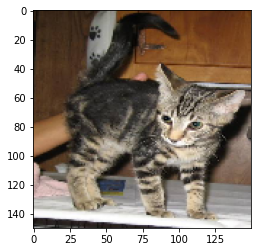

In [11]:
plt.imshow(sample_img_tensor[0])

In [12]:
cnn_prediction = num2class_label_transformer(basic_cnn.predict_classes(sample_img_tensor, verbose=0))
cnn_img_aug_prediction = num2class_label_transformer(img_aug_cnn.predict_classes(sample_img_tensor, verbose=0))
tlearn_cnn_prediction = num2class_label_transformer(tl_cnn.predict_classes(get_bottleneck_features(vgg_model, 
                                                                                                    sample_img_tensor), 
                                                                            verbose=0))
tlearn_cnn_img_aug_prediction = num2class_label_transformer(tl_img_aug_cnn.predict_classes(sample_img_tensor, verbose=0))
tlearn_cnn_finetune_img_aug_prediction = num2class_label_transformer(tl_img_aug_finetune_cnn.predict_classes(sample_img_tensor, 
                                                                                                         verbose=0))

print('Predictions for our sample image:\n', 
      '\nBasic CNN:', cnn_prediction, 
      '\nCNN with Img Augmentation:', cnn_img_aug_prediction, 
      '\nPre-trained CNN (Transfer Learning):', tlearn_cnn_prediction,
      '\nPre-trained CNN with Img Augmentation (Transfer Learning):', tlearn_cnn_img_aug_prediction, 
      '\nPre-trained CNN with Fine-tuning & Img Augmentation (Transfer Learning):', tlearn_cnn_finetune_img_aug_prediction)

Predictions for our sample image:
 
Basic CNN: ['cat'] 
CNN with Img Augmentation: ['cat'] 
Pre-trained CNN (Transfer Learning): ['cat'] 
Pre-trained CNN with Img Augmentation (Transfer Learning): ['cat'] 
Pre-trained CNN with Fine-tuning & Img Augmentation (Transfer Learning): ['cat']


In [13]:
tl_img_aug_finetune_cnn.layers[0].layers[1:9]

In [14]:
from tensorflow.keras import models

# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in tl_img_aug_finetune_cnn.layers[0].layers[1:9]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=tl_img_aug_finetune_cnn.layers[0].layers[1].input, outputs=layer_outputs)
# This will return a list of 8 Numpy array
# one array per layer activation
activations = activation_model.predict(sample_img_tensor)

In [15]:
print ('Sample layer shape:', activations[0].shape)
print('Sample convolution (activation map) shape:', activations[0][0, :, :, 1].shape)

Sample layer shape: (1, 150, 150, 64)
Sample convolution (activation map) shape: (150, 150)


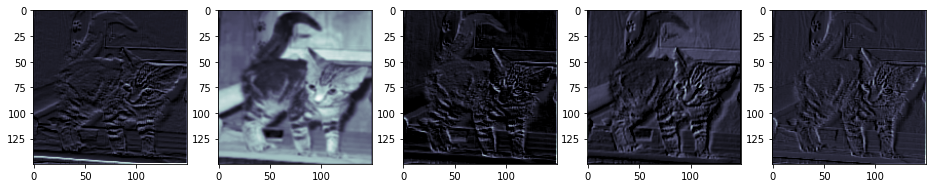

In [16]:
fig, ax = plt.subplots(1,5, figsize=(16, 6))
ax[0].imshow(activations[0][0, :, :, 10], cmap='bone')
ax[1].imshow(activations[0][0, :, :, 25], cmap='bone')
ax[2].imshow(activations[0][0, :, :, 40], cmap='bone')
ax[3].imshow(activations[0][0, :, :, 55], cmap='bone')
ax[4].imshow(activations[0][0, :, :, 63], cmap='bone')

E:\Anaconda\envs\2022 AI\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


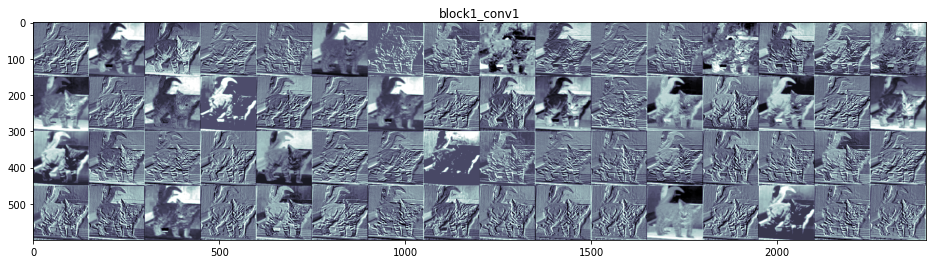

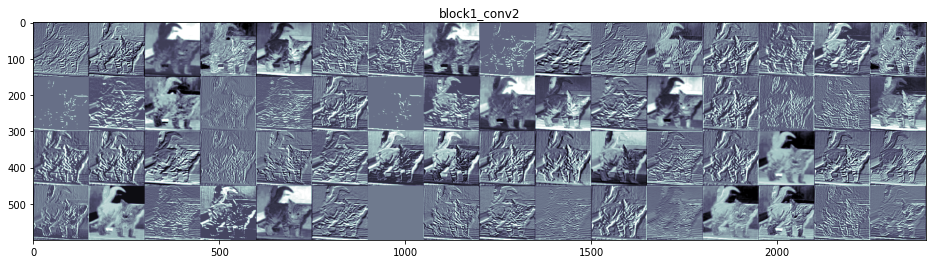

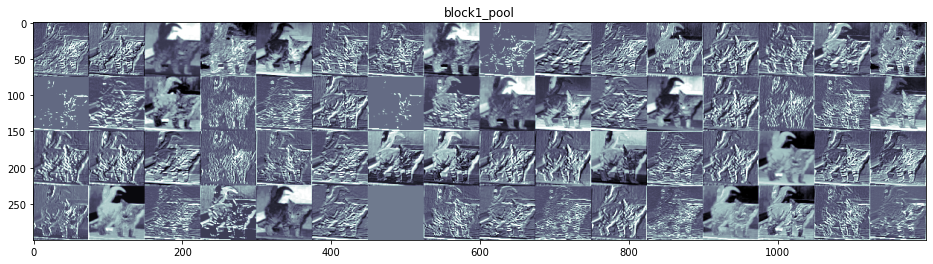

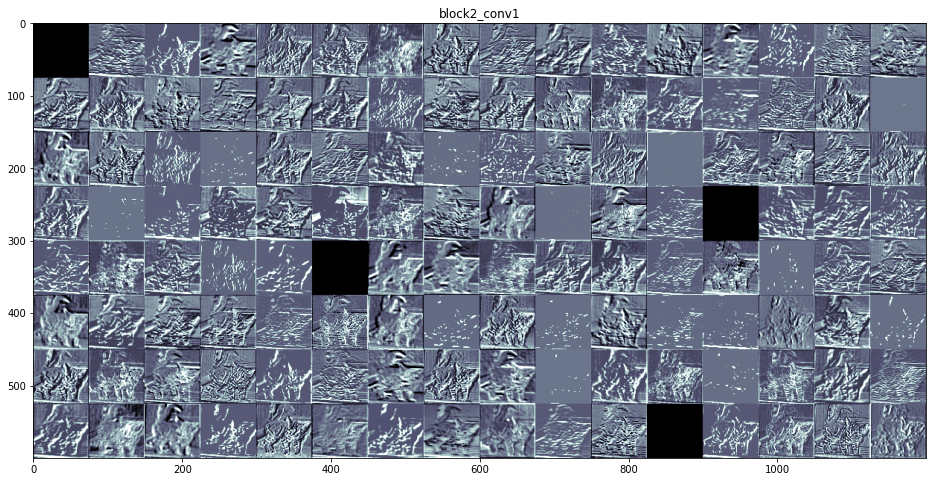

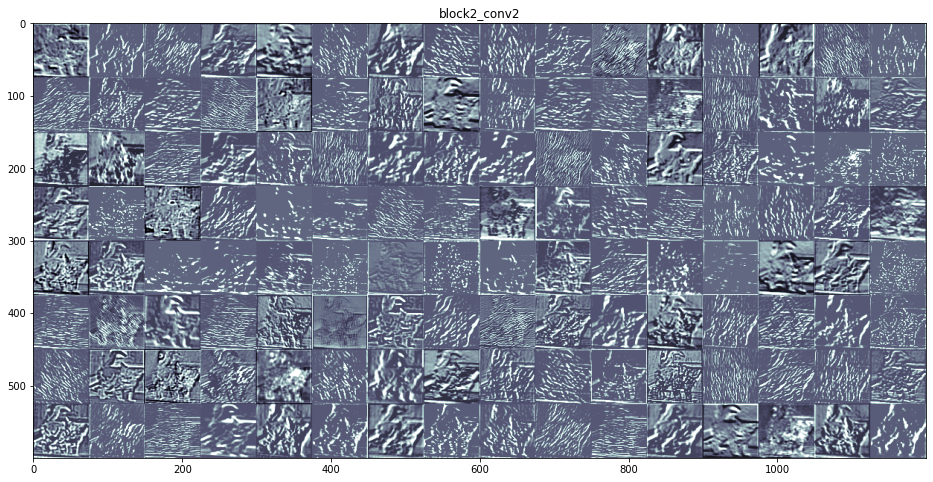

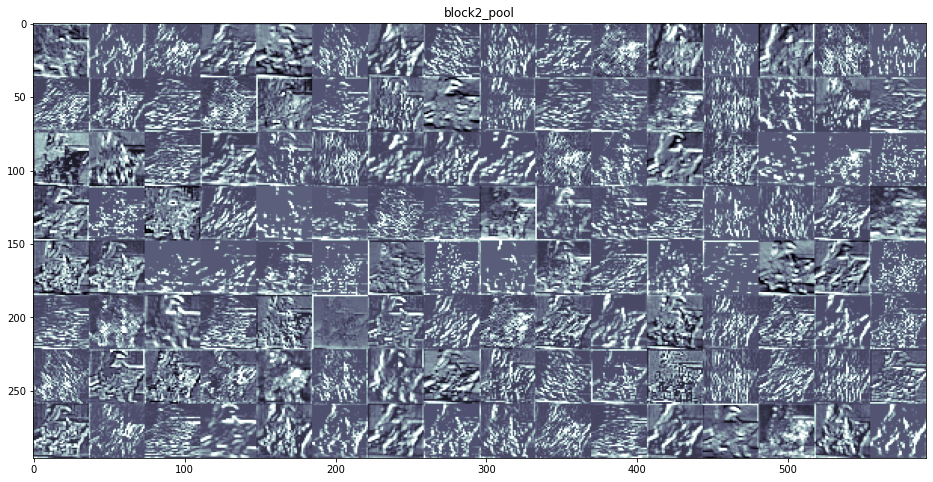

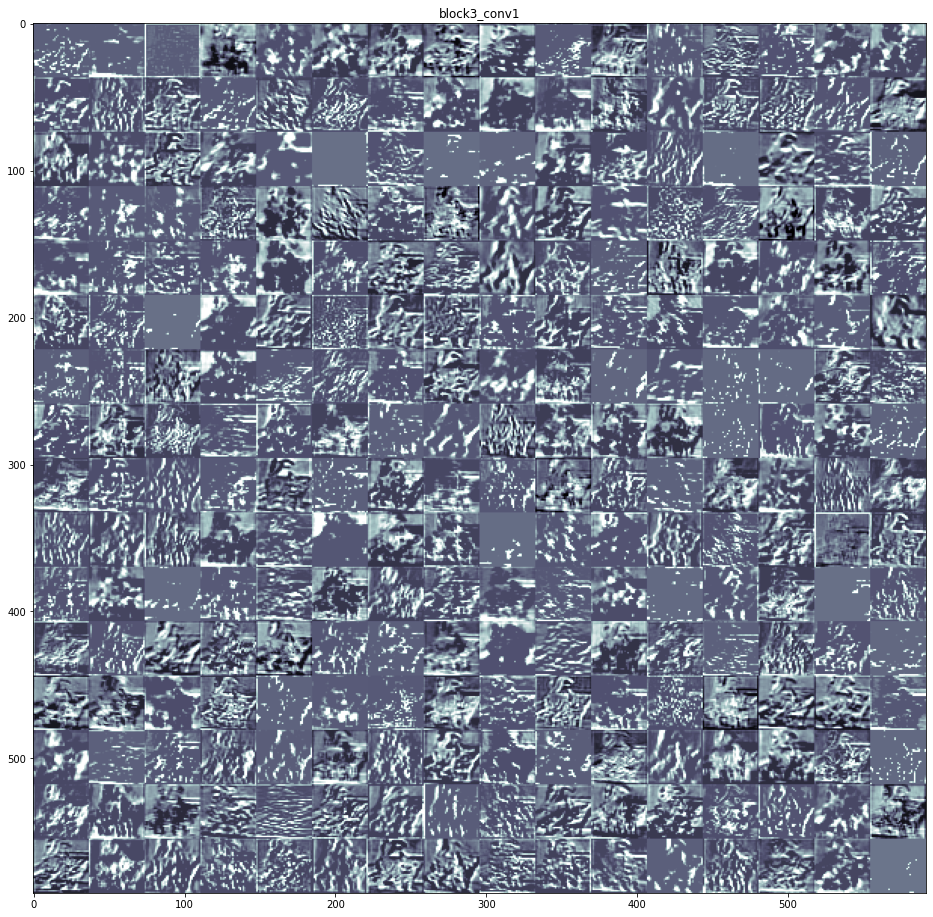

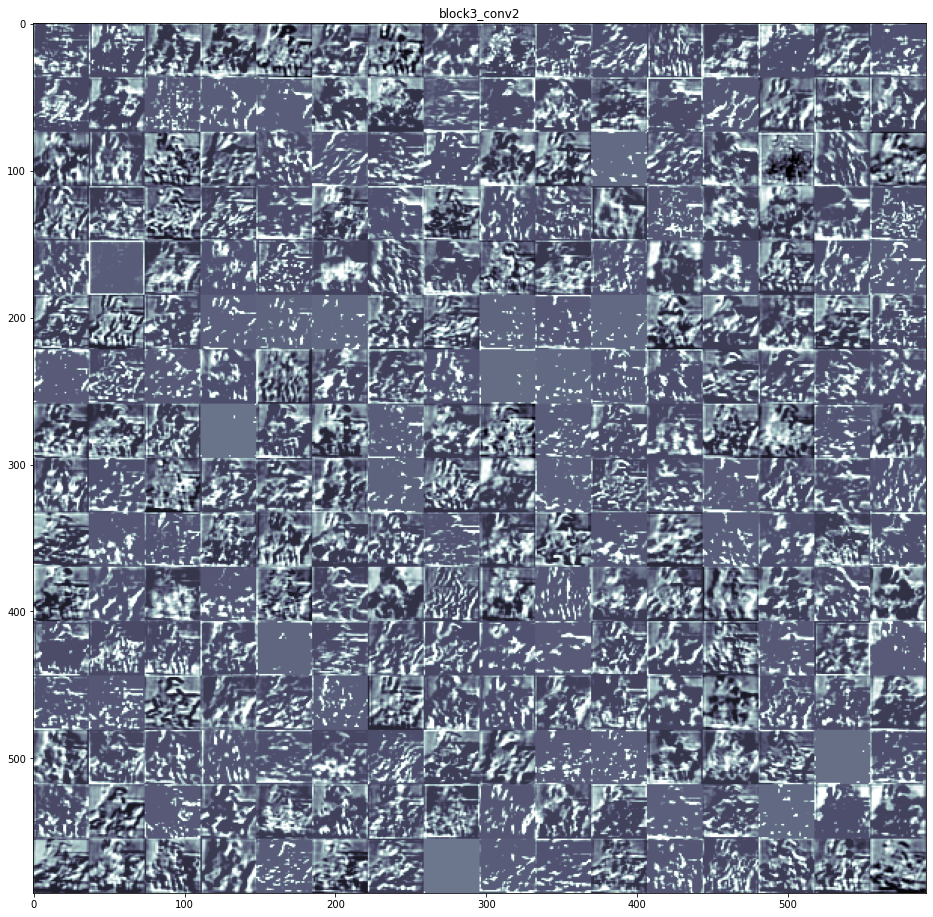

In [17]:
import tensorflow.keras

# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in tl_img_aug_finetune_cnn.layers[0].layers[1:9]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='bone')

In [18]:
IMG_DIM = (150, 150)

test_files = glob.glob('test_data/*')
test_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in test_files]
test_imgs = np.array(test_imgs)
test_labels = [fn.split('\\')[1].split('.')[0].strip() for fn in test_files]

print('Test dataset shape:', test_imgs.shape)

Test dataset shape: (1000, 150, 150, 3)


In [19]:
test_imgs_scaled = test_imgs.astype('float32')
test_imgs_scaled /= 255

test_labels_enc = class2num_label_transformer(test_labels)

print(test_labels[0:5], test_labels_enc[0:5])

['cat', 'cat', 'cat', 'cat', 'cat'] [0, 0, 0, 0, 0]


In [20]:
predictions = basic_cnn.predict_classes(test_imgs_scaled, verbose=0)
predictions = num2class_label_transformer(predictions)

meu.display_model_performance_metrics(true_labels=test_labels, predicted_labels=predictions, 
                                      classes=list(set(test_labels)))

Model Performance metrics:
------------------------------
Accuracy: 0.783
Precision: 0.7831
Recall: 0.783
F1 Score: 0.783

Model Classification report:
------------------------------
              precision    recall  f1-score   support

         cat       0.79      0.78      0.78       500
         dog       0.78      0.79      0.78       500

    accuracy                           0.78      1000
   macro avg       0.78      0.78      0.78      1000
weighted avg       0.78      0.78      0.78      1000


Prediction Confusion Matrix:
------------------------------
            Predicted:     
                   cat  dog
Actual: cat        388  112
        dog        105  395


C:\ARK\2022 AI\model_evaluation_utils.py:62: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  labels=level_labels),
C:\ARK\2022 AI\model_evaluation_utils.py:64: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  labels=level_labels))


In [21]:
predictions = img_aug_cnn.predict_classes(test_imgs_scaled, verbose=0)
predictions = num2class_label_transformer(predictions)

meu.display_model_performance_metrics(true_labels=test_labels, predicted_labels=predictions, 
                                      classes=list(set(test_labels)))

Model Performance metrics:
------------------------------
Accuracy: 0.83
Precision: 0.8304
Recall: 0.83
F1 Score: 0.8299

Model Classification report:
------------------------------
              precision    recall  f1-score   support

         cat       0.84      0.81      0.83       500
         dog       0.82      0.85      0.83       500

    accuracy                           0.83      1000
   macro avg       0.83      0.83      0.83      1000
weighted avg       0.83      0.83      0.83      1000


Prediction Confusion Matrix:
------------------------------
            Predicted:     
                   cat  dog
Actual: cat        406   94
        dog         76  424


C:\ARK\2022 AI\model_evaluation_utils.py:62: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  labels=level_labels),
C:\ARK\2022 AI\model_evaluation_utils.py:64: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  labels=level_labels))


In [22]:
test_bottleneck_features = get_bottleneck_features(vgg_model, test_imgs_scaled)

predictions = tl_cnn.predict_classes(test_bottleneck_features, verbose=0)
predictions = num2class_label_transformer(predictions)

meu.display_model_performance_metrics(true_labels=test_labels, predicted_labels=predictions, 
                                      classes=list(set(test_labels)))

Model Performance metrics:
------------------------------
Accuracy: 0.891
Precision: 0.8932
Recall: 0.891
F1 Score: 0.8909

Model Classification report:
------------------------------
              precision    recall  f1-score   support

         cat       0.86      0.93      0.89       500
         dog       0.92      0.85      0.89       500

    accuracy                           0.89      1000
   macro avg       0.89      0.89      0.89      1000
weighted avg       0.89      0.89      0.89      1000


Prediction Confusion Matrix:
------------------------------
            Predicted:     
                   cat  dog
Actual: cat        464   36
        dog         73  427


C:\ARK\2022 AI\model_evaluation_utils.py:62: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  labels=level_labels),
C:\ARK\2022 AI\model_evaluation_utils.py:64: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  labels=level_labels))


In [23]:
predictions = tl_img_aug_cnn.predict_classes(test_imgs_scaled, verbose=0)
predictions = num2class_label_transformer(predictions)

meu.display_model_performance_metrics(true_labels=test_labels, predicted_labels=predictions, classes=list(set(test_labels)))

Model Performance metrics:
------------------------------
Accuracy: 0.907
Precision: 0.907
Recall: 0.907
F1 Score: 0.907

Model Classification report:
------------------------------
              precision    recall  f1-score   support

         cat       0.91      0.90      0.91       500
         dog       0.90      0.91      0.91       500

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.91      0.91      0.91      1000


Prediction Confusion Matrix:
------------------------------
            Predicted:     
                   cat  dog
Actual: cat        452   48
        dog         45  455


C:\ARK\2022 AI\model_evaluation_utils.py:62: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  labels=level_labels),
C:\ARK\2022 AI\model_evaluation_utils.py:64: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  labels=level_labels))


In [24]:
predictions = tl_img_aug_finetune_cnn.predict_classes(test_imgs_scaled, verbose=0)
predictions = num2class_label_transformer(predictions)

meu.display_model_performance_metrics(true_labels=test_labels, predicted_labels=predictions, 
                                      classes=list(set(test_labels)))

Model Performance metrics:
------------------------------
Accuracy: 0.964
Precision: 0.964
Recall: 0.964
F1 Score: 0.964

Model Classification report:
------------------------------
              precision    recall  f1-score   support

         cat       0.96      0.97      0.96       500
         dog       0.97      0.96      0.96       500

    accuracy                           0.96      1000
   macro avg       0.96      0.96      0.96      1000
weighted avg       0.96      0.96      0.96      1000


Prediction Confusion Matrix:
------------------------------
            Predicted:     
                   cat  dog
Actual: cat        484   16
        dog         20  480


C:\ARK\2022 AI\model_evaluation_utils.py:62: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  labels=level_labels),
C:\ARK\2022 AI\model_evaluation_utils.py:64: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  labels=level_labels))


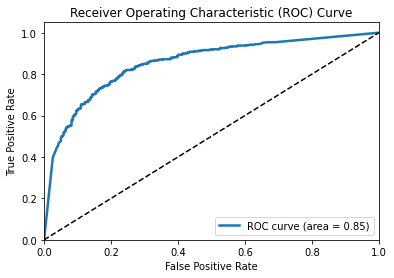

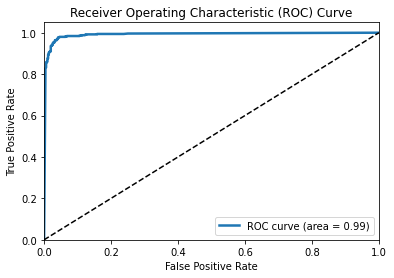

In [25]:
meu.plot_model_roc_curve(basic_cnn, test_imgs_scaled, 
                                  true_labels=test_labels_enc, class_names=[0, 1])

meu.plot_model_roc_curve(tl_img_aug_finetune_cnn, test_imgs_scaled, 
                                  true_labels=test_labels_enc, class_names=[0, 1])